## Import

In [1]:
import os, sys, inspect, time

import numpy as np
import torch 
import matplotlib.pyplot as plt
torch.multiprocessing.set_sharing_strategy('file_system')

import discrepancy, visualization
from algorithms import ABC_algorithms, SMCABC, SMC2ABC, SNLABC, SNL2ABC
from problems import problem_GC

import utils_os, utils_math

%load_ext autoreload
%autoreload 2

## Problem Definition

visualizing p(x|theta)


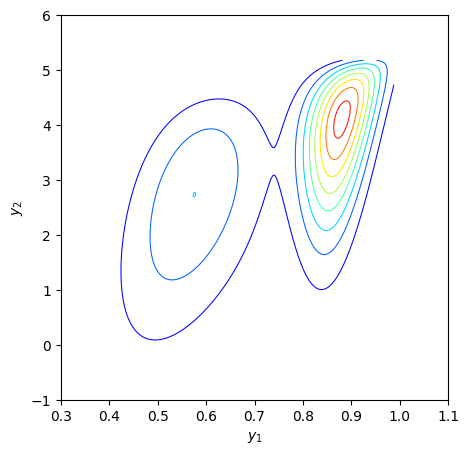

<Figure size 500x400 with 0 Axes>

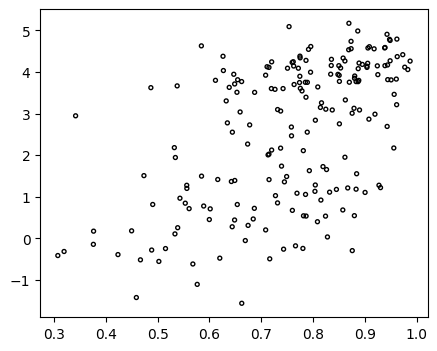

In [2]:
DIR = 'results/GC'                                             
RERUN = not utils_os.is_file_exist(DIR, 'true_samples.npy') 

## Define the problem
problem = problem_GC.Gaussian_Copula_Problem(N=500, n=200)
true_theta = problem.get_true_theta()

## Get x_o ~ p(x|theta)
if RERUN:
    # observed stat
    problem.data_obs = problem.simulator(true_theta)
    problem.y_obs = problem.statistics(data=problem.data_obs, theta=true_theta)
    utils_os.save_object(DIR, 'data_obs', problem.data_obs)
    utils_os.save_object(DIR, 'y_obs', problem.y_obs)
    
    # collect samples
    true_samples = problem.sample_from_true_posterior()
    utils_os.save_object(DIR, 'true_samples', true_samples)
else:
    true_samples = utils_os.load_object(DIR, 'true_samples.npy')
    problem.data_obs  = utils_os.load_object(DIR, 'data_obs.npy')
    problem.y_obs  = utils_os.load_object(DIR, 'y_obs.npy')
    
## Visualize the problem
problem.visualize()
# visualization.plot_likelihood(samples=true_samples, log_likelihood_function=problem.log_likelihood, dimensions=(0,1))
# visualization.plot_likelihood(samples=true_samples, log_likelihood_function=problem.log_likelihood, dimensions=(1,2))
# visualization.plot_likelihood(samples=true_samples, log_likelihood_function=problem.log_likelihood, dimensions=(0,2))
plt.figure(figsize=(5,4))
visualization.plot_samples(problem.data_obs)

## Inference

### SMC

iteration  0
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  1
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  2
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  3
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  4
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  5
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  6
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  7
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  8
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  9
# of cpus =  4
> learning fake posterior 
fitting Gaussian copula progress= 0.0 loss= 1690.969482421875
fitting Gaussian copula progress= 0.1 loss= 812.580078125
fitting Gaussian copula progress= 0.2 loss= 513.4939575195312
fitting

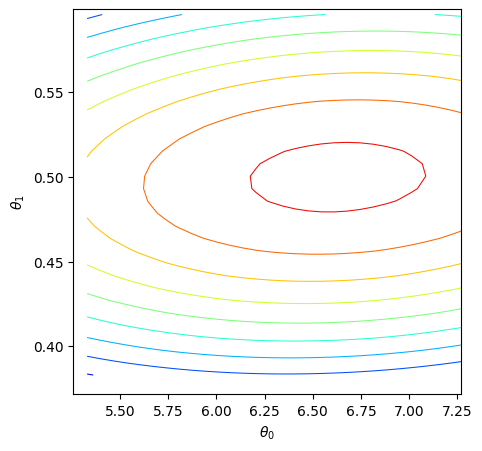

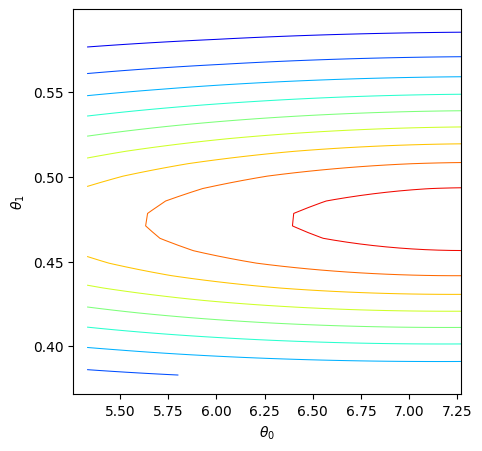

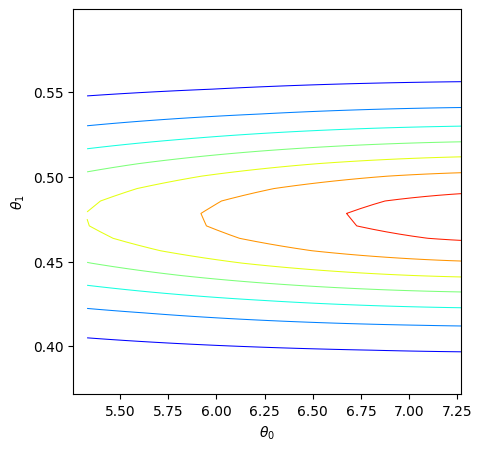

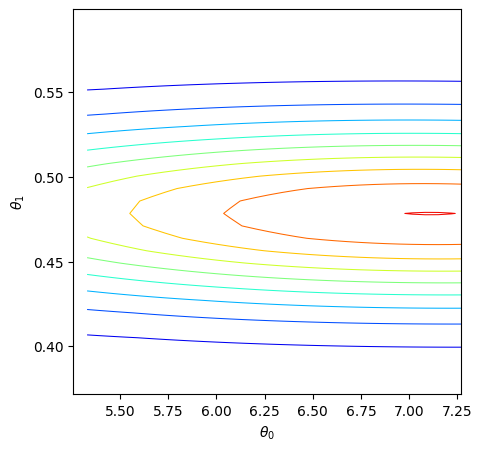

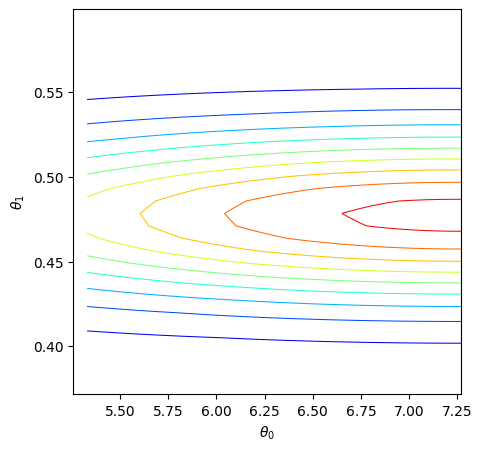

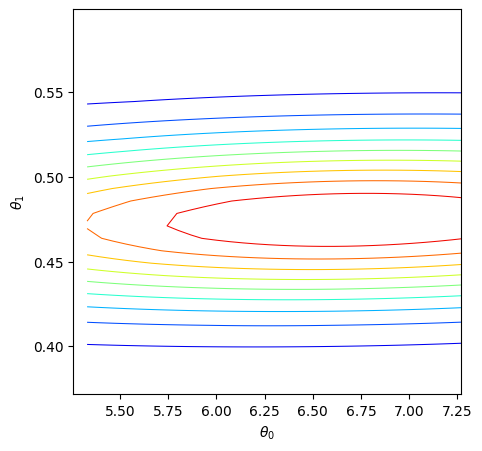

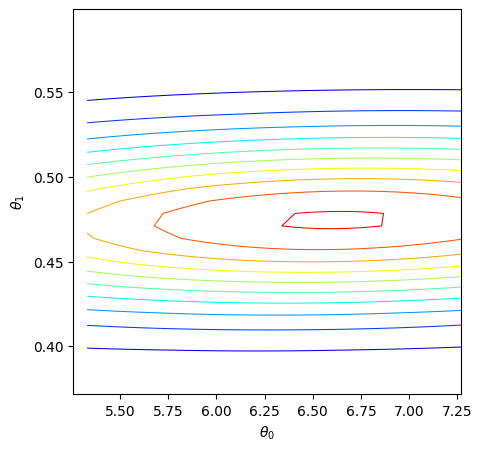

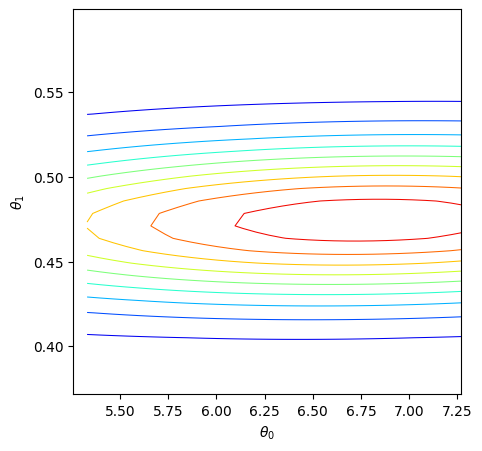

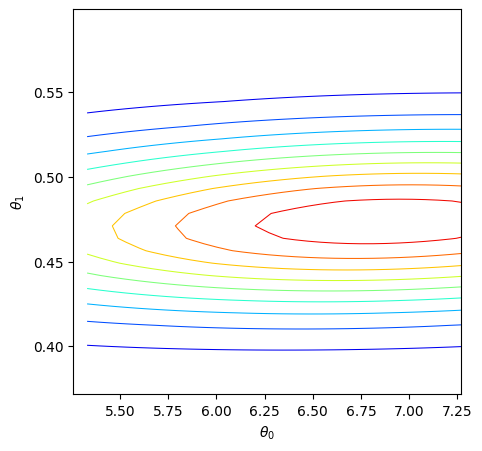

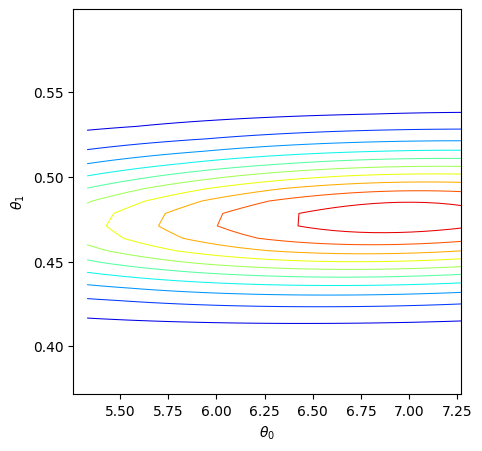

In [3]:
## Sequential Monte Carlo ABC

hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda:1'
hyperparams.num_sim = 4000                        # number of simulations
hyperparams.num_samples = 200                     # number of samples to represent posterior
hyperparams.L = 10                                 # number of rounds in sequential learning

smc_abc = SMCABC.SMC_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
smc_abc.run()

JSD_smc_array = []
for l in range(hyperparams.L):
    print('round =', l)
    smc_abc.posterior = smc_abc.posterior_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=smc_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, smc_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_smc_array.append(JSD)
    print('JSD smc = ', JSD)
utils_os.save_object(DIR, 'PREDEP_SMC', JSD_smc_array)

iteration  0
# of cpus =  4

 > fitting encoder
summary statistic dim = 6 original dim = 41
architecture [41, 100, 100, 6]
finished: t= 0 loss= -0.22898492217063904 loss val= -0.2533780038356781 best loss -0.2533780038356781
finished: t= 200 loss= -4.467802047729492 loss val= -3.4174187183380127 best loss -3.566197156906128
finished: t= 400 loss= -5.999505996704102 loss val= -4.506494045257568 best loss -4.8922576904296875
finished: t= 600 loss= -14.623144149780273 loss val= -11.142398834228516 best loss -11.779885292053223
finished: t= 800 loss= -17.010604858398438 loss val= -12.15694808959961 best loss -12.97486686706543
finished: t= 1000 loss= -22.82286262512207 loss val= -17.297576904296875 best loss -17.297576904296875
finished: t= 1200 loss= -37.379825592041016 loss val= -28.704322814941406 best loss -32.04180145263672
finished: t= 1400 loss= -47.06796646118164 loss val= -32.53663635253906 best loss -39.343544006347656
finished: t= 1600 loss= -53.04571533203125 loss val= -34.7137

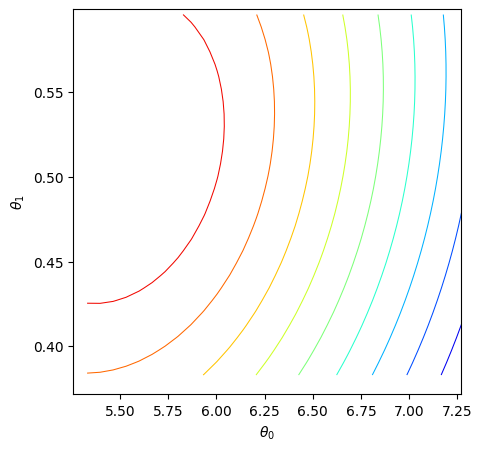

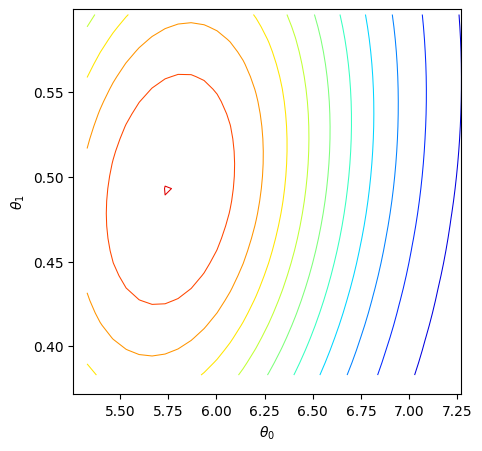

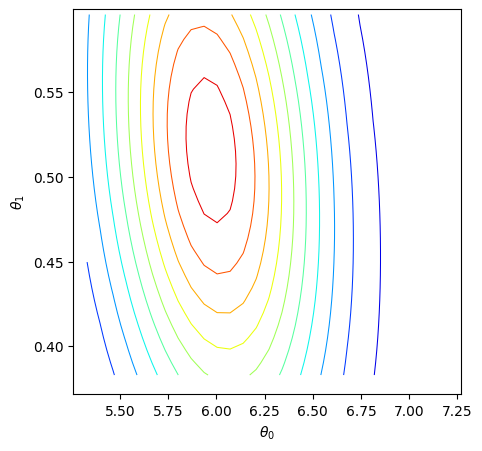

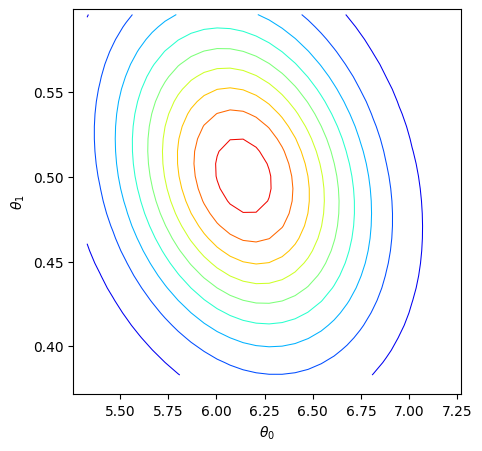

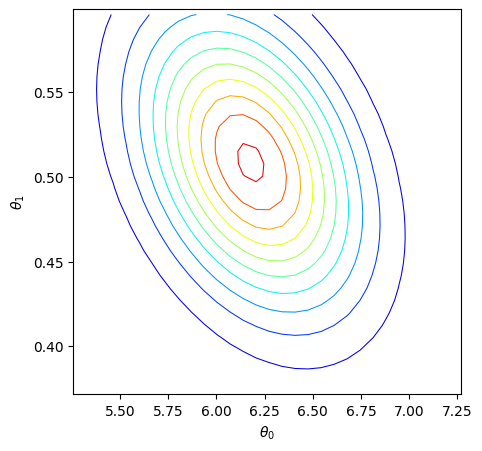

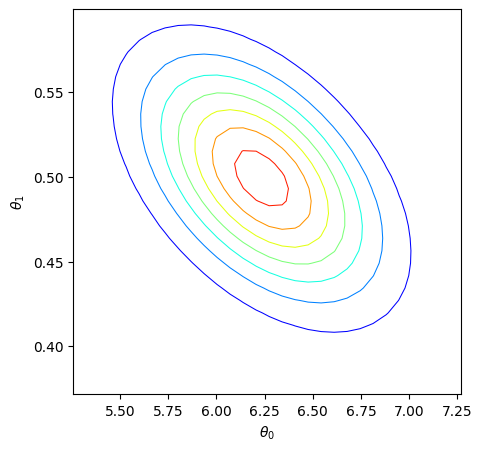

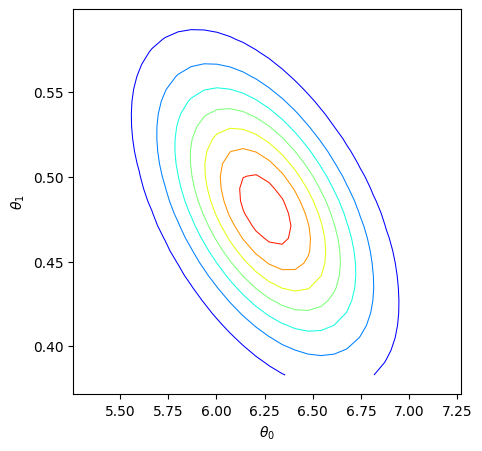

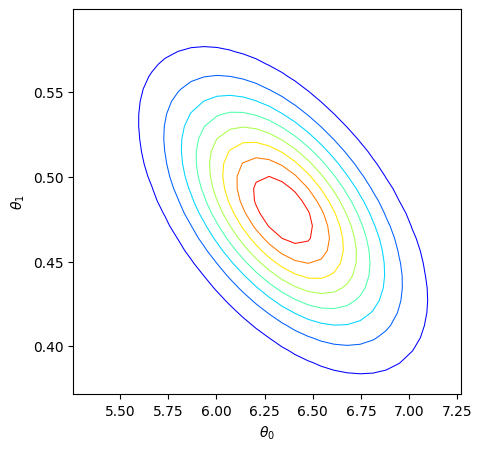

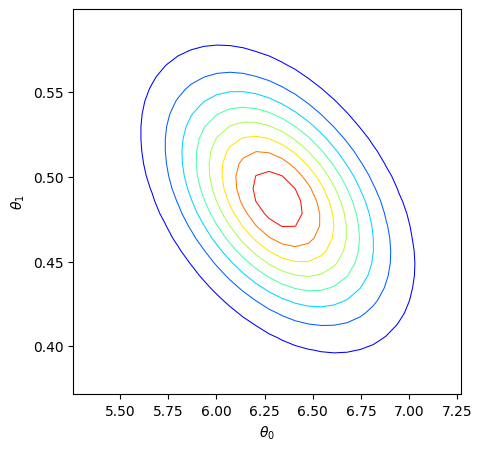

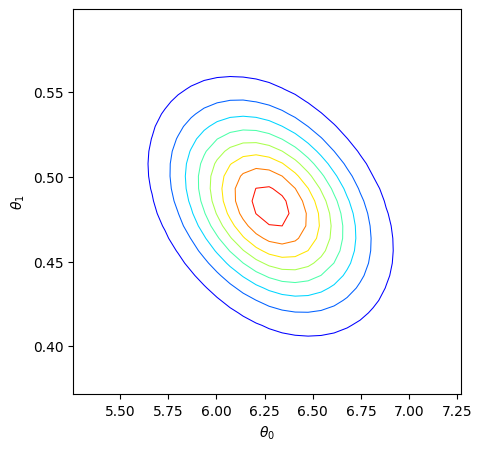

In [4]:
## Sequential Monte Carlo ABC +

hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda'
hyperparams.num_sim = 4000                       # number of simulations
hyperparams.num_samples = 200                    # number of samples to represent posterior
hyperparams.L = 10                                # number of learning rounds
hyperparams.type = 'plain'                       # the network architecture of S(x)
hyperparams.stat = 'infomax'                     # statistics function: infomax/moment/score  
hyperparams.estimator = 'PREDEP'                    # MI estimator; JSD (accurate) or DC (fast)

smc2_abc = SMC2ABC.SMC2_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
smc2_abc.run()

JSD_smc2_array = []
for l in range(len(smc2_abc.posterior_array)):
    print('l=', l)
    smc2_abc.l = l
    smc2_abc.posterior = smc2_abc.posterior_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=smc2_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, smc2_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_smc2_array.append(JSD)
    print('JSD smc2 = ', JSD)
utils_os.save_object(DIR, 'PREDEP_SMC2', JSD_smc2_array)

### SNL


 SNL ABC
iteration  0
# of cpus =  4
finished: t= 0 loss= 158.3712158203125 loss val= 162.2379150390625 best loss 162.2379150390625
finished: t= 200 loss= -29.666696548461914 loss val= -27.867950439453125 best loss -27.867950439453125
finished: t= 400 loss= -56.9696044921875 loss val= -54.471229553222656 best loss -54.49275588989258
finished: t= 600 loss= -69.2230453491211 loss val= -65.5899658203125 best loss -65.5899658203125
finished: t= 800 loss= -75.23332977294922 loss val= -69.33245086669922 best loss -69.50048065185547
finished: t= 1000 loss= -78.6152572631836 loss val= -70.48280334472656 best loss -71.4694595336914
finished: t= 1200 loss= -82.15049743652344 loss val= -72.6910629272461 best loss -73.34881591796875
finished: t= 1400 loss= -84.22441864013672 loss val= -74.73461151123047 best loss -74.8236312866211
finished: t= 1600 loss= -86.9535903930664 loss val= -74.70701599121094 best loss -75.26427459716797
finished: t= 1800 loss= -88.19884490966797 loss val= -74.25677490234

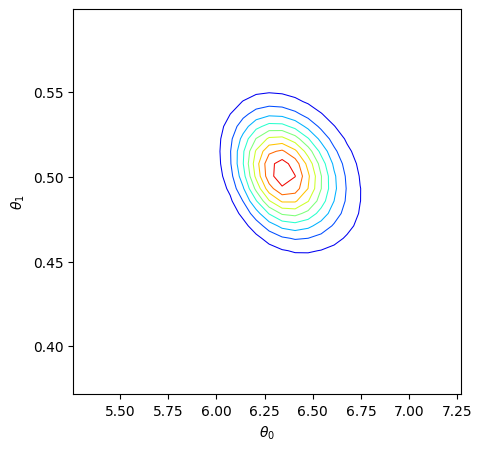

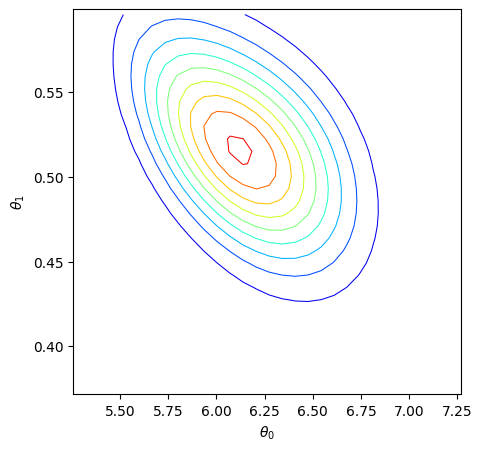

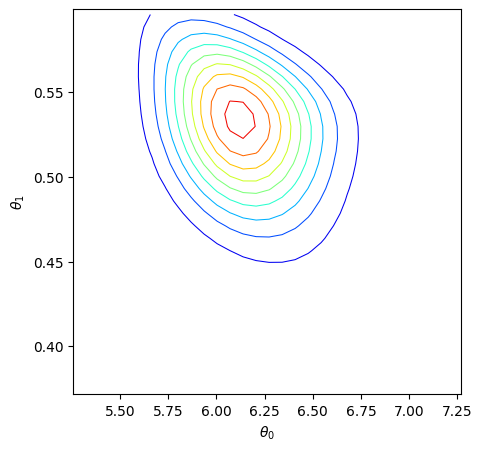

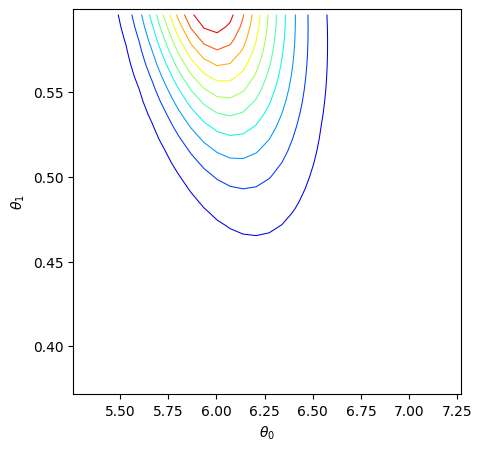

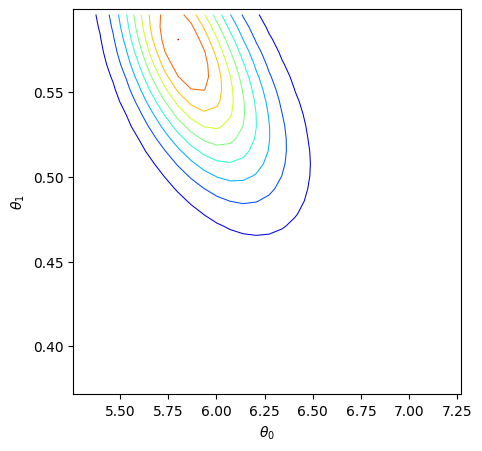

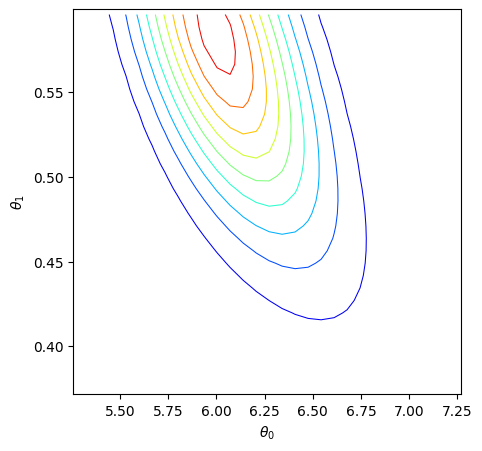

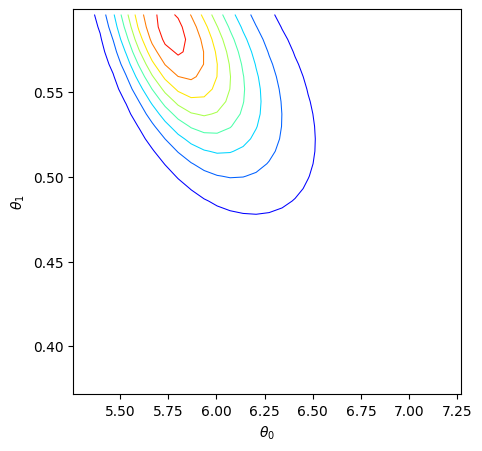

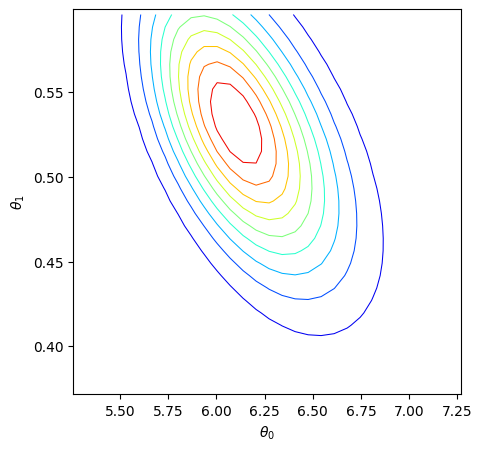

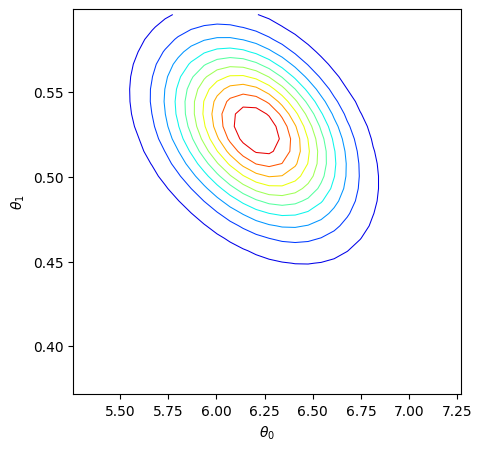

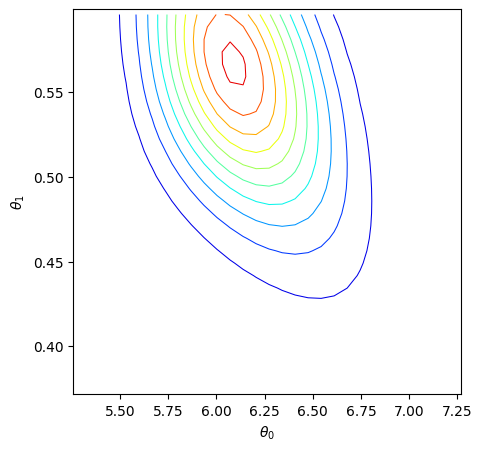

In [5]:
## Sequential Neural Likelihood
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda'
hyperparams.num_sim = 4000
hyperparams.L = 10

print('\n SNL ABC')
snl_abc = SNLABC.SNL_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
snl_abc.run()

JSD_array = []
for l in range(len(snl_abc.nde_array)):
    print('l=', l)
    snl_abc.nde_net = snl_abc.nde_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=snl_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, snl_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_array.append(JSD)
    print('JSD snl = ', JSD)
utils_os.save_object(DIR, 'PREDEP_SNL', JSD_array)

iteration  0
# of cpus =  4

 > fitting encoder
summary statistic dim = 6 original dim = 41
architecture [41, 100, 100, 6]
finished: t= 0 loss= -0.15753887593746185 loss val= -0.17435505986213684 best loss -0.17435505986213684
finished: t= 200 loss= -3.7185733318328857 loss val= -3.942136287689209 best loss -4.449724197387695
finished: t= 400 loss= -10.754742622375488 loss val= -9.816438674926758 best loss -11.184464454650879
finished: t= 600 loss= -13.884087562561035 loss val= -10.594046592712402 best loss -12.056472778320312
finished: t= 800 loss= -22.17473793029785 loss val= -13.656028747558594 best loss -15.93736457824707
finished: t= 1000 loss= -46.66085433959961 loss val= -22.83635711669922 best loss -27.267732620239258
finished: t= 1200 loss= -54.281105041503906 loss val= -28.768157958984375 best loss -30.085651397705078
finished: t= 1400 loss= -53.361080169677734 loss val= -28.612327575683594 best loss -31.56658172607422
finished: t= 1600 loss= -59.00236511230469 loss val= -28.

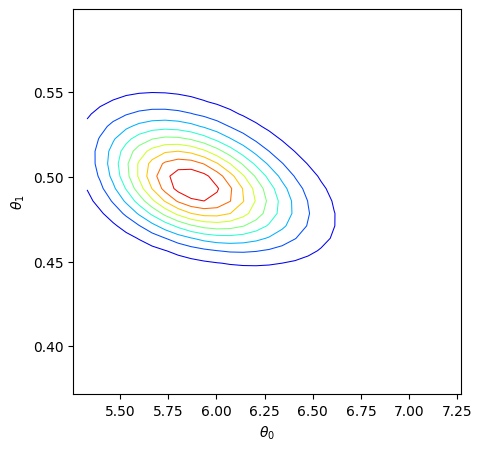

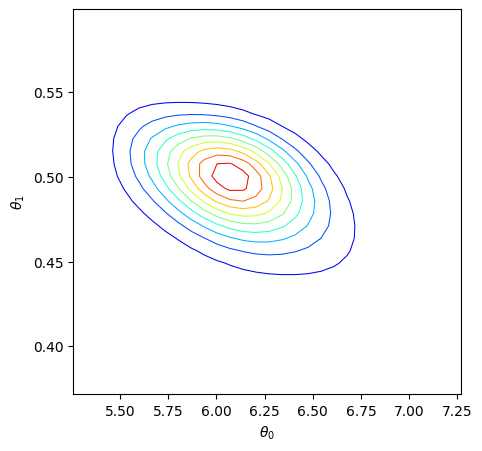

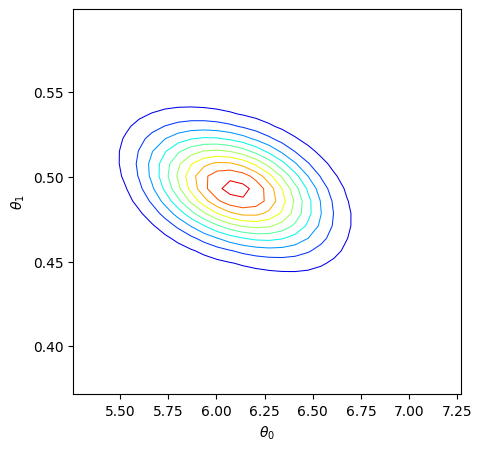

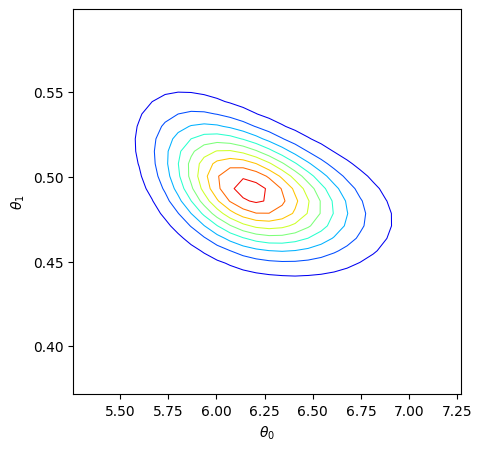

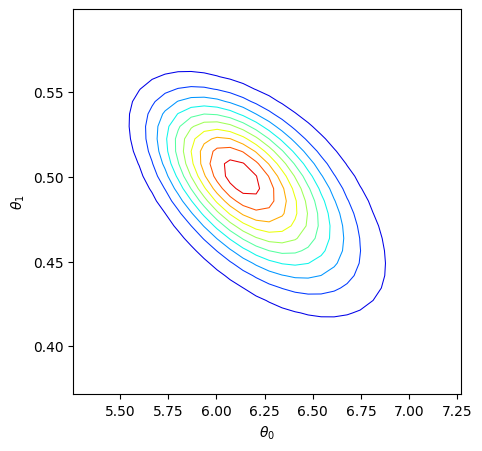

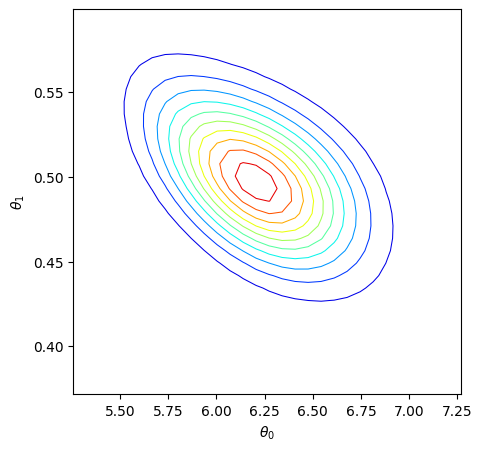

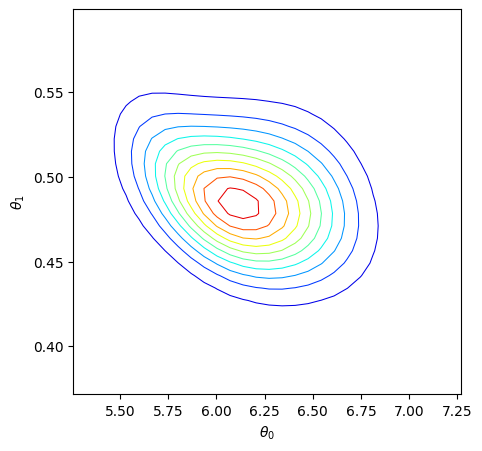

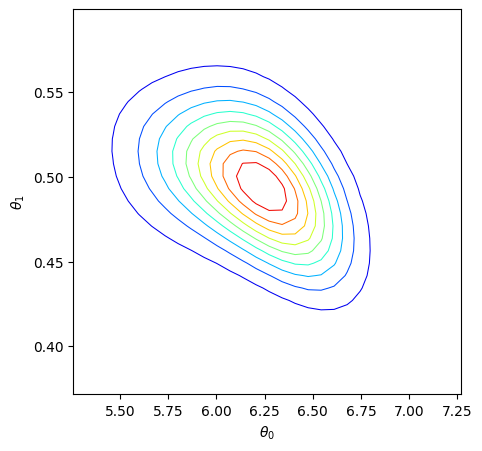

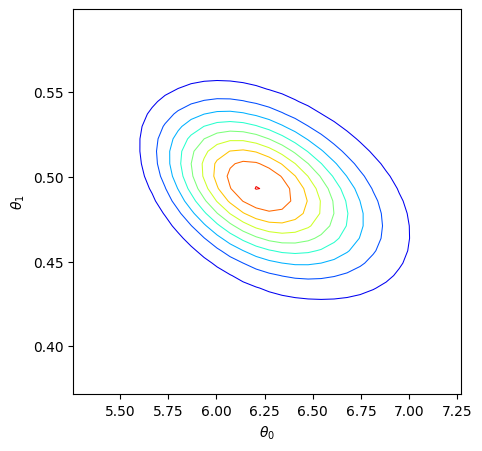

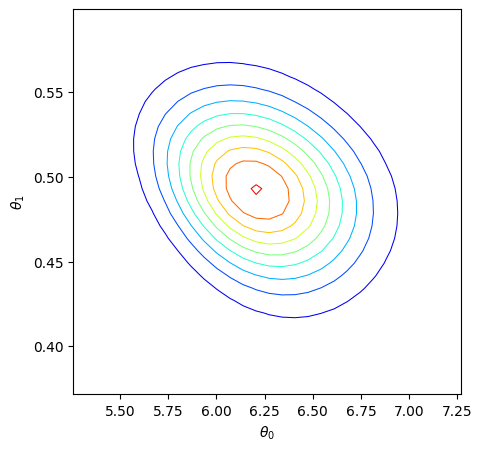

In [6]:
### Sequential Neural Likelihood + 
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda'
hyperparams.num_sim = 4000                       # number of simulations
hyperparams.L = 10                                # number of learning rounds
hyperparams.type = 'plain'                       # the network architecture of S(x)
hyperparams.stat = 'infomax'                     # statistics function: infomax/moment/score  
hyperparams.estimator = 'PREDEP'                     # MI estimator; JSD (accurate) or DC (fast)
hyperparams.nde = 'MAF'                          # nde; MAF (D>1) or MDN (D=1)

snl2_abc = SNL2ABC.SNL2_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
snl2_abc.run()

JSD_array = []
for l in range(len(snl2_abc.nde_array)):
    print('l=', l)
    snl2_abc.set(l=l)
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=snl2_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, snl2_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_array.append(JSD)
    print('JSD snl+ = ', JSD)
utils_os.save_object(DIR, 'PREDEP_SNL2', JSD_array)